# Social distancing

Quarantine seems to be very effective, especially when carried out strongly enough and when combined with effective detection of exposed individuals. But you need to get a lot right for it to work. Maybe there's another way?

```{margin}

Some people *never* develop symptoms: for some reason their immune systems suppress the disease enough to keep them well, but not enough to eliminate it and stop them being infectious. The most famous case of this phenomenon is "Typhoid Mary", who infected a large number of people with typhoid fever despite showing no symptoms herself {cite}`MTK13`.
```

Let's go back to basics. In SEIR-style diseases we have the possibility of individuals walking around and spreading the disease without showing any symptoms. There is by definition no way (absent testing) to spot these individuals until (and unless) they show symptoms. So the challenge is to stop these infectious-but-asymptomatic individuals from coming into contact with susceptible individuals.

What is we re-structure the contact network so that people only have contact with a small group of people, and reduce the amount of mixing between those groups? If someone is infected in spite of everything then they'll probably infect their own group, but they'll be less opportunity to infect other groups. This strategy is referred to as **social distancing**, reducing and re-structuring the connections within a population.   

## A socially distanced social network

Social distancing is another topological approach to epidemic control. It works by changing the network over which the disease operates, rather than addressing the disease itself. s such it's well-suited to new diseases and those for which there are few effective therapies. 

In [1]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_formats = {'svg', 'png'}
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')

What does "social distancing" mean in network terms? We can understand it best by thinking about the actual conditions of socially-distant lockdown, and then re-creating this structure as a network.

The idea of social distancing is to place individuals in small "bubbles" of contact &ndash; typically just their own immediate family &ndash; with whom they interact strongly, and weaken the connections that any family member has with individuals in other bubbles. Within a bubble, infection of one person will probably transfer quickly to most or all all of the other members. But the ability of the disease to pass between bubbles is substantially reduced, since there is relatively little contact between them. One can reduce the inter-bubble transmission even further using quarantine when someone realises they are infected.

In network terms, the bubbles are {ref}`complete graphs <sec:network-complete>` (everyone in a bubble meets everyone else) whose size depends on the size of the family. We could set all families to the same size, say 4; alternatively we could draw family sizes from some probability distribution where the average size of a family is 4.5 (2 adults with the proverbial 2.5 children) but we allow larger and smaller families to occur. Larger families risk more infections if a member is infected.

We now need to link the bubbles. In each bubble, some person or people meet with the outside world: perhaps they're the designated shopper, or someone in a key role whose work brings them into contact with others. We then need to connect these people to other bubbles.

This description still leaves quite a lot to be decided:

- What is the distribution of family sizes? Are large families really unusual? Or do they follow a "normal" distribution?
- How many people in each family connect to the outside? Is it always one or two? Might a large family have more contacts?
- How do those in contact outside their family group connect with others? Are some people significantly more connected than others?

These decisions are simply additional {ref}`degrees of freedom <sec:seir-degrees-of-freedom>` (again) for our model &ndash; with all that this entails.

Creating such a network means addressing all these issues. There's a trick we can perform, though. Notice that while the detailed choices change, the structure of the network doesn't. This means that, just as our disease models have parameters that we can change, so does our socially-distanced network &ndash; with the difference that the network parameters are given by choices of probability distributions as well as single numbers. But the solution is the same: define what it means to build the network, providing these distributions as parameters that are "plugged in" to the same structure-building process.

Building the network involves a complicated piece of code &ndash; the most complicated we've seen so far.

In [136]:
def social_distance_graph(N, clusterSizeDistribution, contactDistribution, clusterContactDistribution):
    # build the initial graph
    g = networkx.Graph()
    
    # build the clusters, each being a complete graph K_s of size s,
    # labelled uniquely within the overall graph
    rng = numpy.random.default_rng()
    n = 0
    cid = 1
    clusters = []
    while n < N:
        # build the graph
        s = clusterSizeDistribution()
        K_s = networkx.complete_graph(s)
        
        # relabel the graph so all nodes in the social distance
        # graph have unique integer labels
        networkx.relabel_nodes(K_s, lambda l: n + l, copy=False)
        
        # add to the graph and list of clusters
        # label edges with the cluster they belong to (numbered from 1)
        # and the size of the cluster
        g.add_nodes_from(K_s.nodes, cluster=cid, cluster_size=s)
        g.add_edges_from(K_s.edges, cluster=cid, cluster_size=s)
        clusters.append(K_s)
        n += s
        cid += 1
        
    # decide on how many contact nodes per cluster
    contacts = []
    for c in clusters:
        s = c.order()
        d = contactDistribution(s)
        contacts.append(d)
        
    # decide on the arity of each contact node
    stubs = []
    for i in range(len(clusters)):
        c = clusters[i]
        ls = list(c.nodes())[:contacts[i]]   # first i node labels (since all nodes are identical in K_s) 
        for l in ls:
            # draw the number of contacts for this node
            e = clusterContactDistribution(n)
            
            # append e copies of the node label to the list of stubs
            stubs.extend([l] * e)
    
    # if number of stubs isn't even, add one to a randomly-chosen node
    if len(stubs) % 2 > 0:
        us = list(set(stubs))                # don't favour already-high-degree nodes
        j = rng.integers(len(us))
        stubs.append(us[j])
        
    # shuffle the stubs until there are no edge pair with the same endpoints
    rng.shuffle(stubs)                       # initial shuffle (may leave self-loops)
    while True:
        # look for pairtings of stubs and others within the same cluster,
        # and break them randomly (without changing the degree distribution)
        swaps = 0
        for i in range(0, len(stubs), 2):
            if g.nodes[stubs[i]]['cluster'] == g.nodes[stubs[i + 1]]['cluster']:
                # self loop, swap with another randomly-chosen stub
                j = rng.integers(len(stubs))
                t = stubs[i + 1]
                stubs[i + 1] = stubs[j]
                stubs[j] = t
                
                swaps += 1
        if swaps == 0:
            # no swaps, we're finished
            break

    # connect the nodes by pulling pairs 
    for i in range(0, len(stubs), 2):
        # label inter-bubble edges as cluster 0 of size 0
        g.add_edge(stubs[i], stubs[i + 1], cluster=0, cluster_size=0)
    
    # return the graph and list of cluster sizes
    return (g, list(map(lambda h: h.order(), clusters)))

This function takes four parameters &ndash; the size of network and three probability-distribution functions &ndfash; and returns a network and a list of the bubble sizes. Within the network it creates the social bubbles and labels them uniquely, and then connects the bubbles together randomly. 

In [10]:
def averageFamily():
    rng = numpy.random.default_rng()
    return max(int(rng.normal(4.5, 2)), 1)

In [11]:
def coupleOfContacts(s):
    rng = numpy.random.default_rng()
    return max(int(rng.normal(s / 2, s / 2)), 1)    

In [19]:
def normalInterBubble(n):
    rng = numpy.random.default_rng()
    return max(int(rng.normal(numpy.sqrt(n), numpy.sqrt(n))), 1)

In [137]:
N = 1000

In [138]:
(g, clusters) = social_distance_graph(N, averageFamily, coupleOfContacts, normalInterBubble)

In [145]:
def draw_social_distance(g, cmap=None, color='cluster_size', ax=None):
    # fill in defaults
    if cmap is None:
        cmap = plt.get_cmap('viridis')
    if ax is None:
        ax = plt.gca()
    
    # work out the colours 
    ncs = list(map(lambda n: g.nodes[n][color], g.nodes()))
    ecs = list(map(lambda e: g.edges[e][color], g.edges()))
               
    # draw with spring layout, which seems to give good results
    networkx.draw_spring(g,
                         ax=ax,
                         with_labels=False,
                         node_size=50,
                         node_color=ncs, edge_color=ecs,
                         cmap=cmap, edge_cmap=cmap)

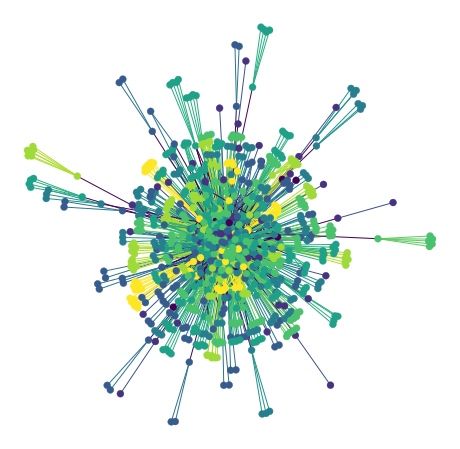

In [147]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

draw_social_distance(g)

plt.savefig('social-distancing.png', dpi=300)
_ = plt.show()

In [118]:
print('Mean cluster size {s:.2f}'.format(s=numpy.mean(clusters)))

Mean cluster size 3.98


## Questions for discussion

- The case of Typhoid Mary raises some troubling questions. Is it right to loack someone up when they're done nothing personally wrong, to protect the community?
- Social distancing doesn't have to be uniform to everyone. Some people are in more need of protection ("shielding") than others. How could we introduce this into our model?
- 